# NFW

In [1]:
#i = 0   #kalo udah bisa, iterasi 20_000 burn in 5_000
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner
import math
from IPython.display import display, Math
from scipy.stats import norm

G = 4.2994e-6 # (km/s)**2 * kpc/Msun
H0 = 72 #km s^-1 Mpc^-1
delta_c = 200
h = H0/100
C = 1000  #Mpc to kpc

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Data #i nya yang diubah
galaxy_data = pd.read_csv('C:/Users/Azriel Julio Dante/Desktop/S2/Thesis/Olah Data/MCMCdataobs.csv', index_col=0)
rc_data= pd.read_csv('C:/Users/Azriel Julio Dante/Desktop/S2/Thesis/Olah Data/MCMCrcobs.csv', index_col=0)
i = 40
ID = galaxy_data.iloc[i]['Galaxy']
galaxy = galaxy_data[galaxy_data.Galaxy == ID]
rc = rc_data[rc_data['ID'] == ID].reset_index(drop=True)
rad = rc['R']
Dobs = galaxy_data.iloc[i]['D']
Dobs_err = galaxy_data.iloc[i]['e_D']
incobs = galaxy_data.iloc[i]['Inc']
incobs_err = galaxy_data.iloc[i]['e_Inc']
Vobs = rc['Vobs']
Vobs_err = rc['e_Vobs']
Vdisk = rc['Vdisk']
Vgas = rc['Vgas']
Vmax = rc['Vobs'].max()
Mstar = galaxy_data.iloc[i]['Mstar']
Mgas = 1.33* galaxy_data.iloc[i]['Mgas']
M_Ldisk_init = 0.5
print('ID = ',ID)
print('Npoint = ', len(rad))
print('Vmax = ',Vmax)
print('M/L_disk = '  , M_Ldisk_init)
print('inc = ',incobs)
print('inc_err = ',incobs_err)
print('D = ',Dobs)
print('D_err = ',Dobs_err)

#initial param
alpha = 1
beta = 3
gamma = 1
V200_init = 0.8*Vmax
r200_init = 1000*V200_init/(H0*np.sqrt(delta_c/2))
M200_init = V200_init**2 *r200_init/(G)
log_C200_init = 0.830-(0.098*np.log10(M200_init/((10**(12))*(h**(-1)))))
C200_init = 10**log_C200_init
rmin2 = r200_init/C200_init
rs = rmin2 / ((2-gamma)/(beta-2))**(1/alpha)
#x = r/rs
M_Ldisk_init = 0.5
print('V200 = ',V200_init)
print('C200 = ',C200_init)
print('M200 = ',M200_init)
print('log M200 = ', np.log10(M200_init))
print('M/L_disk = '  , M_Ldisk_init)
print('rs = ',rs)
print('R200 = ',r200_init)

ID =  DDO133
Npoint =  15
Vmax =  48.92
M/L_disk =  0.5
inc =  36.9
inc_err =  3.15
D =  3.5
D_err =  0.35
V200 =  39.136
C200 =  10.276766702210665
M200 =  19363727286.06059
log M200 =  10.286988957516
M/L_disk =  0.5
rs =  5.28916897022319
R200 =  54.355555555555554


In [4]:
#MCMC
def main(p0, nwalkers, niter, ndim, ln_posterior, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=data)

    print("Running burn-in...")
    p0 = sampler.run_mcmc(p0, 2000, progress=True) #500 iterasi pertama ditetapkan sebagai burn-in
    sampler.reset() #reset sampler sebelum melakukan iterasi utama

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

In [5]:
#koreksi data menggunakan jarak dan inklinasi
def r_kor(r,D):
    rad = r*D/Dobs
    return rad

def Vgas_kor(Vgas,D):
    Vgasfit = Vgas *np.sqrt(D/Dobs)
    return Vgasfit

def Vdisk_kor(Vd,D,MLdisk):
    Vdiskfit = Vd*np.sqrt(D/Dobs)*np.sqrt(MLdisk)
    return Vdiskfit
    
def Vobs_kor(Vobs,inc):
    Vobsfit = Vobs * np.sin(np.radians(incobs))/np.sin(np.radians(inc))
    return Vobsfit

def Vobserr_kor(Vobs_err,inc):
    Vobserrfit = Vobs_err * np.sin(np.radians(incobs))/np.sin(np.radians(inc))
    return Vobserrfit

# Halo NFW
def VDM(V200, C200, r): # parameter bebas ditetapkan V200 dan C200
    # V200 dan C200 adalah kecepatan dan konsentrasi pada R200, rs adalah skala radius
    rs = 1000 * V200 / (H0*C200*np.sqrt(delta_c/2)) #kpc dikali 1000
    x = r/rs
    vh = V200 * np.sqrt((C200/x)*(np.log(1+x) - x/(1+x))/(np.log(1+C200) - C200/(1+C200)))
    return vh

#Fungsi model kecepatan rotasi total
def Vtot(vDM, Vdisk, Vgas):
    #ML_d adalah mass to light ratio komponen disk
    return np.sqrt(vDM**2 + Vdisk**2 + Vgas*np.abs(Vgas))

In [6]:
#Likelihood
def ln_likelihood(theta, r, Vobs, Vdisk, Vgas, Vobs_err):
    D, inc, V200, C200, M_Ld = theta
    #data
    korrad = r_kor(r,D)
    korVdisk = Vdisk_kor(Vdisk,D,M_Ld)
    korVgas = Vgas_kor(Vgas,D)
    korVobs = Vobs_kor(Vobs,inc)
    korVobs_err = Vobserr_kor(Vobs_err,inc)
    vDM = VDM(V200, C200, korrad)
    vtot = Vtot(vDM, korVdisk, korVgas)
    lik = np.sum(-np.log(np.sqrt(2*math.pi)*korVobs_err) - ((korVobs - vtot)**2)/(2*(korVobs_err**2)))
    return lik

#Prior
def ln_prior(theta):
    D, inc, V200, C200, M_Ld = theta
    r200_pred = 1000 * V200 / (H0 * np.sqrt(delta_c / 2))
    M200_pred = V200 ** 2 * r200_pred / G
    log_C200_pred = 1.025 - (0.097 * np.log10(M200_pred / (10 ** 12 * (h ** -1))))
    C200_pred = 10**log_C200_pred
    if 1.0 < V200 < 250.0:  # km/s
        p1 = 1 / 250  # Flat prior
    else:
        p1 = 0
    if C200 > 0:
        p2 = norm.pdf(x=C200, loc=C200_pred, scale=(10 ** 0.11 - 1))
    else:
        p2 = 0
    if 0.0 < M_Ld :  #default M_Ld > 0.0
        p3 = norm.pdf(x=M_Ld, loc=0.5, scale=(10 ** 0.1 - 1))
    else:
        p3 = 0
    if D > 0:
        p4 = norm.pdf(x=D,loc=Dobs,scale=Dobs_err)
    else:
        p4 = 0
    if 0.0 < inc < 90.0:
        p5 = norm.pdf(x=inc,loc=incobs,scale=incobs_err)
    else:
        p5 = 0
    
    return np.log(p1 * p2 * p3 * p4 * p5)

#Posterior
def ln_posterior(theta, r, Vobs, Vdisk, Vgas, Vobs_err):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf      
    return lp + ln_likelihood(theta, r, Vobs, Vdisk, Vgas, Vobs_err)

In [7]:
#Menjalankan MCMC
nwalkers = 35 #number of walkers
niter = 10000 #number of iterations #ganti 20000
init_param = np.array([Dobs, incobs, V200_init, C200_init, M_Ldisk_init]) #V200, C200, M/L ambil semuanya secara sembarang dalam rentang prior
ndim = len(init_param) #number of dimension
p0 = [np.array(init_param) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)] #methodology of stepping from one place to a grid to the next

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,ln_posterior,(rad, Vobs, Vdisk, Vgas, Vobs_err)) #run MCMC

Running burn-in...


100%|██████████| 2000/2000 [09:01<00:00,  3.69it/s]


Running production...


100%|██████████| 10000/10000 [42:15<00:00,  3.94it/s]


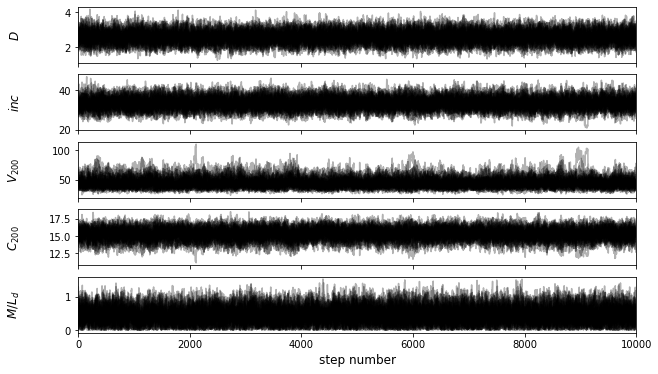

In [8]:
#Membuat plot masing-masing parameter (MCMC chains) untuk mengecek konvergensi
fig, axes = plt.subplots(ndim, figsize=(10, 6), sharex=True)
samples = sampler.get_chain()
labels = [r"$D$",r"$inc$",r"$V_{200}$", r"$C_{200}$", r"$M/L_d$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize=12)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number", fontsize=12);
plt.savefig('1Trace plot {} (NFWkor).jpg'.format(rc.iloc[0]['ID']), bbox_inches = 'tight', dpi=300)

In [9]:
# Flat: concatenating the samples from each walker in the chain
# Discard: menghapus X sampel (flattened) pertama
# Thin: mengambil sampel kelipatan ke-X saja (untuk merampingkan sampel dan menghemat ukuran sampel)
flat_samples = sampler.get_chain(discard=2000, thin=20, flat=True)
np.savetxt("Flat samples {} (NFWkor).txt".format(rc.iloc[0]['ID']), np.c_[flat_samples[:, 0],flat_samples[:, 1],flat_samples[:, 2],flat_samples[:, 3],flat_samples[:, 4]])
tau = sampler.get_autocorr_time()
print(tau)

[ 62.70840701  90.98530785 109.47039956  97.84073848  72.90507985]


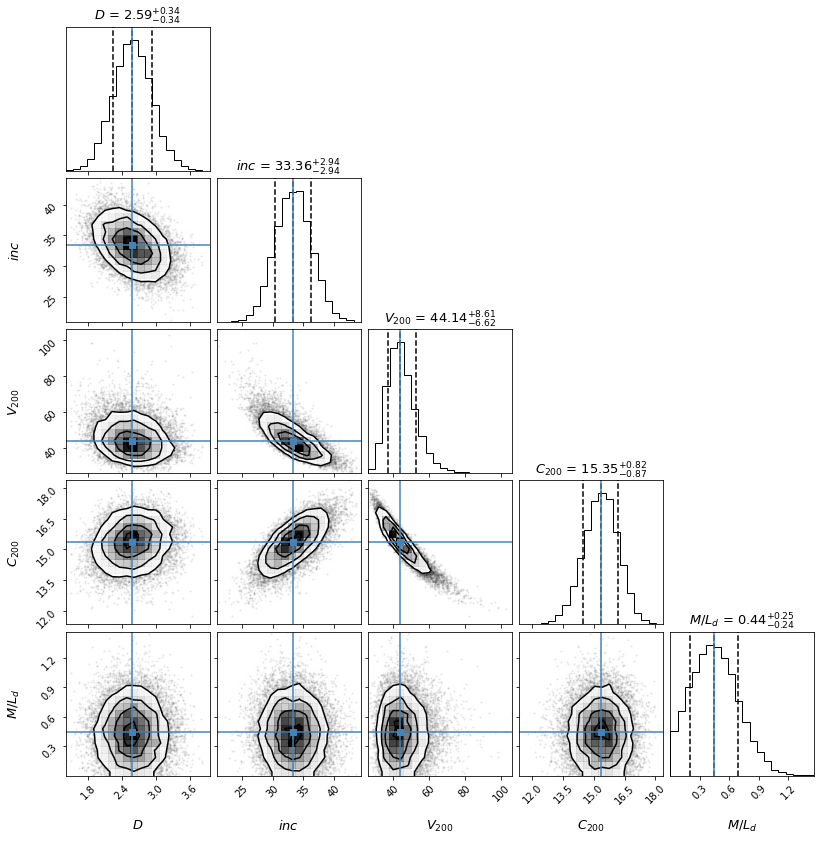

In [10]:
#Membuat corner plot
#Menyimpan nilai best-fit parameter hasil MCMC
flat_samples = np.loadtxt("Flat samples {} (NFWkor).txt".format(rc.iloc[0]['ID']))
labels = [r"$D$",r"$inc$",r"$V_{200}$", r"$C_{200}$", r"$M/L_d$"]

D = np.median(flat_samples[:, 0])
inc = np.median(flat_samples[:, 1])
V200 = np.median(flat_samples[:, 2])
C200 = np.median(flat_samples[:, 3])
ML_d = np.median(flat_samples[:, 4])

fig = corner.corner(flat_samples,show_titles=True,title_kwargs={"fontsize":13},labels=labels,label_kwargs={"fontsize":13},plot_datapoints=True,truths=[D,inc,V200,C200,ML_d],quantiles=[0.16, 0.5, 0.84],dpi=200)
plt.savefig('Corner plot {} (NFWkor).jpg'.format(rc.iloc[0]['ID']), bbox_inches = 'tight', dpi=300)

In [11]:
#Menghitung kecepatan komponen halo DM dan kecepatan total menggunakan nilai best-fit
#koreksi data
fitrad = r_kor(rad,D)
fitVdisk = Vdisk_kor(Vdisk,D,ML_d)#*ML_d
fitVgas = Vgas_kor(Vgas,D)
fitVobs = Vobs_kor(Vobs,inc)
fitVobs_err = Vobserr_kor(Vobs_err,inc)
vDM = VDM(V200, C200, fitrad)
vtot = Vtot(vDM, fitVdisk, fitVgas)

In [12]:
#Menuliskan nilai best-fit parameter hasil MCMC dan reduced chi squared
labels2 = [r'D',r'inc',r'V_{200}', r'C_{200}', r'M/L_d']
ndim = 5
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels2[i])
    display(Math(txt))

rsn = rs = 1000 * V200 / (H0*C200*np.sqrt(delta_c/2)) #kpc dikali 1000
trsn = "\mathrm r_{{s,NFW}} = {0:.3f} \, \\textrm{{kpc}}".format(rsn)
r200n = C200*rsn
tr200n = "\mathrm r_{{200,NFW}} = {0:.3f} \, \\textrm{{kpc}}".format(r200n)
display(Math(trsn))
display(Math(tr200n))

chisq = 0.
for i in range(len(rad)):
    chisq = chisq + (((fitVobs[i] - vtot[i])**2)/(fitVobs_err[i])**2)

red_chisq = chisq/(len(rad) - ndim) #reduced chi squared
txt2 = "\mathrm\chi_{{\\nu}}^2 = {0:.3f}".format(red_chisq)
display(Math(txt2))

#KS and SW test
from scipy import stats
residuals = (fitVobs - vtot)/fitVobs_err
ks_statistic, ks_p_value = stats.kstest(residuals, 'norm')
print("KS Statistic:", ks_statistic)
print("KS p-value:", ks_p_value)

# Perform Shapiro-Wilk test on residuals
shapiro_statistic, shapiro_p_value = stats.shapiro(residuals)
print("Shapiro-Wilk Statistic:", shapiro_statistic)
print("Shapiro-Wilk p-value:", shapiro_p_value)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

KS Statistic: 0.18869976701315871
KS p-value: 0.5945134100632669
Shapiro-Wilk Statistic: 0.9225857786925824
Shapiro-Wilk p-value: 0.2109156805959585


In [13]:
#Komponen kecepatan disk adalah akar dari (ML_d * (Vdisk**2)), dari Li et al. 2020
np.savetxt('Mass model {} (NFWkor).txt'.format(rc.iloc[0]['ID']), np.c_[fitrad,fitVobs,fitVobs_err,fitVgas,fitVdisk,vDM,vtot], fmt='% 1.3f', header='R     Vobs    eVobs  Vgas    Vdisk   VDM     Vtot')

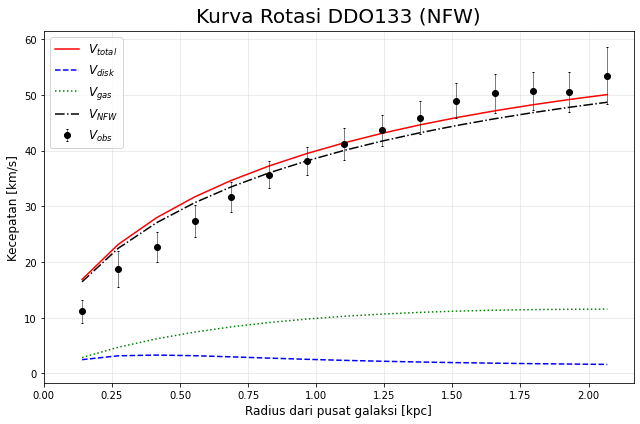

In [14]:
#Membuat plot kurva rotasi
plt.figure(figsize=(9,6))
#plt.axvline(x = rsn, c = 'orchid', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_s$')
plt.plot(fitrad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.errorbar(fitrad, fitVobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(fitrad, fitVdisk, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
plt.plot(fitrad, fitVgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.plot(fitrad, vDM, label = '$V_{NFW}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('Kurva Rotasi {} (NFW)'.format(rc.iloc[0]['ID']), pad=10, size=20)
plt.ylim(Vgas.min()-5,); plt.xlim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi {} (NFWkor).jpg'.format(rc.iloc[0]['ID']), bbox_inches = 'tight', dpi = 300)
plt.show()